In [1]:
#Import libraries to open data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn
import xgboost
from xgboost import XGBClassifier
import matplotlib
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from statistics import mean as stat_mean
from numpy import mean
from numpy import std

### For AFFF-GW

In [2]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [3]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: AFFF-GW


In [4]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [5]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [6]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0,0.1,0.2,0.4,0.8,1]
learning_rate = [0.01, 0.1, 0.2, 0.5]
max_depth = [5,6,7]
n_estimators = [50,100,150]
reg_alpha = [0,0.5, 10, 200]
reg_lambda = [0,0.5, 10, 200]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.850000 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.950000 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.866667 using {'gamma': 0.8, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.873413 using {'gamma': 0.8, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.856667 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.933333 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.875000 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
Best: 0.891667 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0, 'reg_

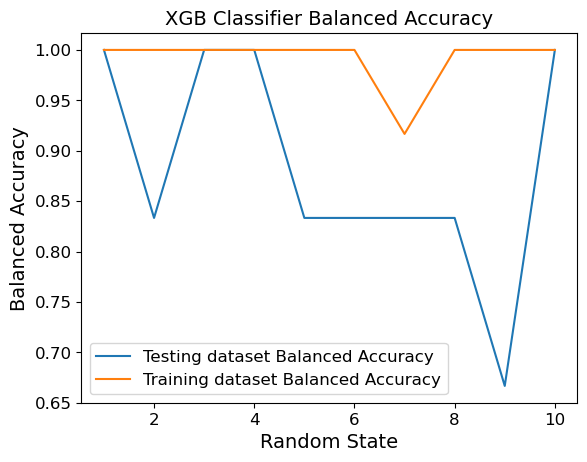

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [7]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-GW.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [8]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1.         1.         1.         1.         1.         1.
 0.91666667 1.         1.         1.        ]
[1.         0.83333333 1.         1.         0.83333333 0.83333333
 0.83333333 0.83333333 0.66666667 1.        ]


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.01226
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.13825
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.72256
Feature: 11, Score: 0.01649
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.05235
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.05809
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

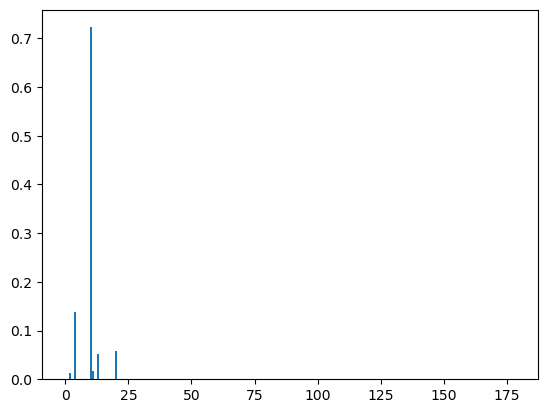

In [9]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 0.8, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0, reg_lambda = 0)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: 0.01226, Standard Deviation: 0.00000
Feature 3: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 4: Average Score: 0.13825, Standard Deviation: 0.00000
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.72256, Standard Deviation: 0.00000
Feature 11: Average Score: 0.01649, Standard Deviation: 0.00000
Feature 12: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 13: Average Score: 0.05235, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

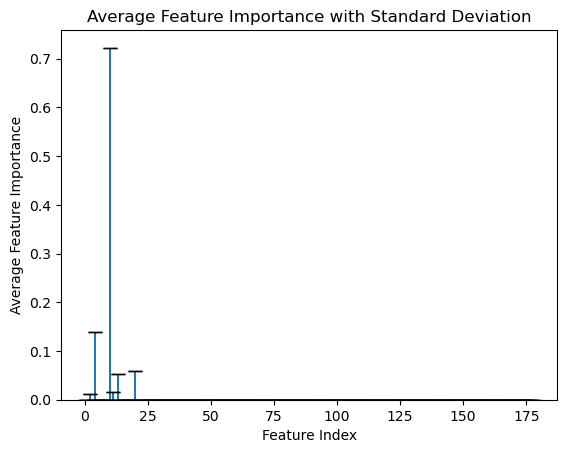

In [14]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 0.8, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0, reg_lambda = 0)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [15]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.72256, Standard Deviation: 0.00000
Feature: 348.939226/8.16, Mean Score: 0.13825, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.05809, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.05235, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.01649, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.01226, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 426.966905/10.31, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 143.10736/7.81, Mean Score: 0.00000, Standard Deviation: 0.00000


In [16]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.72256, Standard Deviation: 0.00000
Feature: 348.939226/8.16, Mean Score: 0.13825, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.05809, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.05235, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.01649, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.01226, Standard Deviation: 0.00000
Feature: 353.30543/16.02, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 239.164508/8.63, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.00000, Standard Deviation: 0.00000


In [17]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_GW.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_GW.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 397.951243/11.28, Mean Score: 0.72256, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [18]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 0.8, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0, reg_lambda = 0)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [19]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [20]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


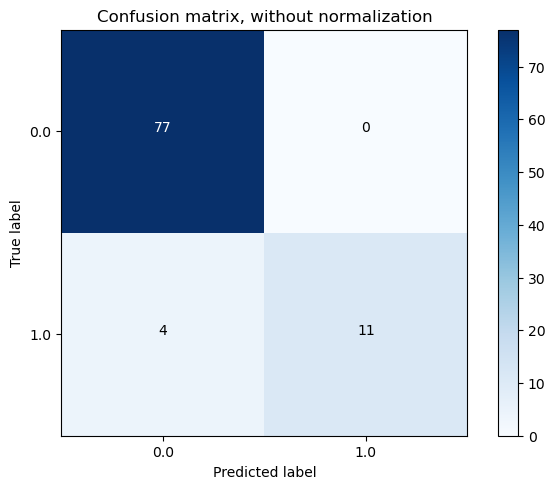

Normalized confusion matrix


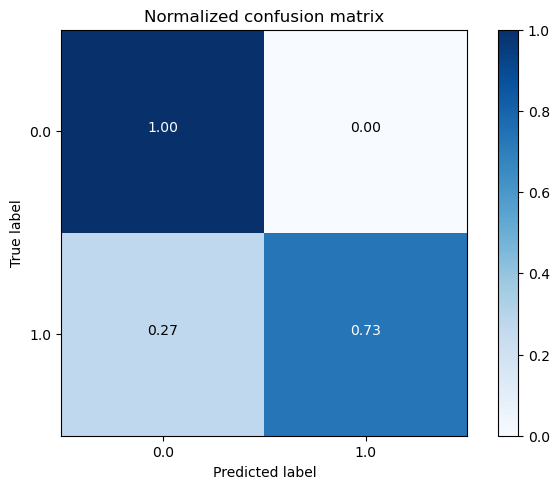

In [21]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For LL

In [22]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [23]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: LL


In [24]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [25]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [26]:
#Running randomized CV to narrow grid for GridSearch CV
#Modified from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

print(random_grid)

{'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'n_estimators': [50, 65, 80, 100, 115, 130, 150], 'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rnd = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rnd, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_1, target_1)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'reg_lambda': 1.6, 'reg_alpha': 12.8, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.6, 'gamma': 0}


In [28]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0, 0.5, 0.6]
learning_rate = [0.1, 0.5, 0.6]
max_depth = [5, 8, 10]
n_estimators = [50, 60, 70]
reg_lambda = [0.5, 1.6, 2]
reg_alpha = [0.5, 0.8, 12.8]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.913333 using {'gamma': 0, 'learning_rate': 0.6, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 2}
Best: 0.934825 using {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.896491 using {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.933333 using {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 1.6}
Best: 0.889474 using {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 1.6}
Best: 0.893333 using {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.900000 using {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.894825 using {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_al

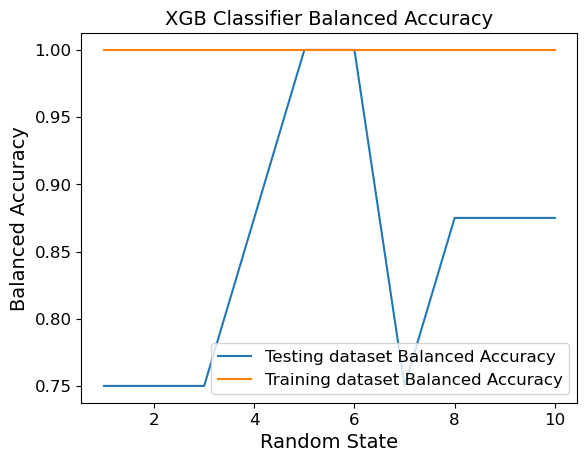

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 5


In [29]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-LL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [30]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.75 0.75 0.75 0.88 1.   1.   0.75 0.88 0.88 0.88]


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.01963
Feature: 12, Score: 0.01091
Feature: 13, Score: 0.01380
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.01704
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00008
Feature: 30, Score: 0.00441
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

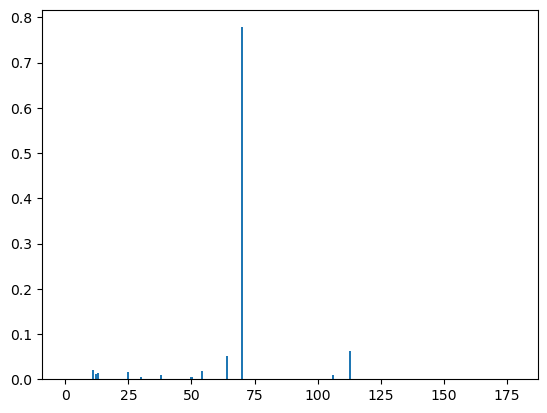

In [31]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0.5, reg_lambda = 1.6)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 3: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 4: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 11: Average Score: 0.01963, Standard Deviation: 0.00000
Feature 12: Average Score: 0.01091, Standard Deviation: 0.00000
Feature 13: Average Score: 0.01380, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

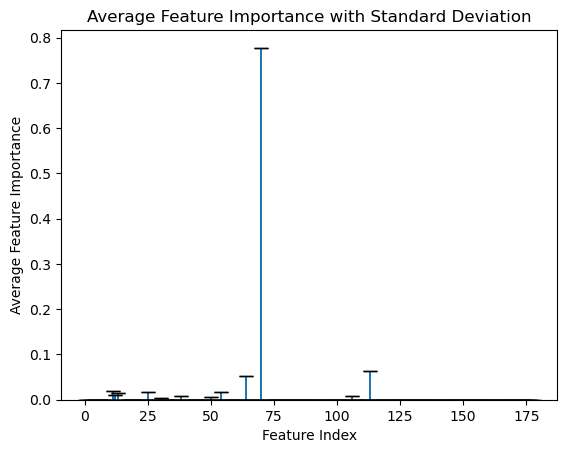

In [32]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0.5, reg_lambda = 1.6)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [33]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 235.043254/7.03, Mean Score: 0.77799, Standard Deviation: 0.00000
Feature: 233.118197/6.98, Mean Score: 0.06248, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.05166, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.01963, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.01792, Standard Deviation: 0.00000
Feature: 249.149073/9.17, Mean Score: 0.01704, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.01380, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.01091, Standard Deviation: 0.00000
Feature: 227.16461/9.57, Mean Score: 0.00916, Standard Deviation: 0.00000
Feature: 395.242801/10.52, Mean Score: 0.00903, Standard Deviation: 0.00000


In [34]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 235.043254/7.03, Mean Score: 0.77799, Standard Deviation: 0.00000
Feature: 233.118197/6.98, Mean Score: 0.06248, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.05166, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.01963, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.01792, Standard Deviation: 0.00000
Feature: 249.149073/9.17, Mean Score: 0.01704, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.01380, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.01091, Standard Deviation: 0.00000
Feature: 227.16461/9.57, Mean Score: 0.00916, Standard Deviation: 0.00000
Feature: 395.242801/10.52, Mean Score: 0.00903, Standard Deviation: 0.00000


In [35]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_ll.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_LL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 235.043254/7.03, Mean Score: 0.77799, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [36]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 50, reg_alpha = 0.5, reg_lambda = 1.6)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [37]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [38]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


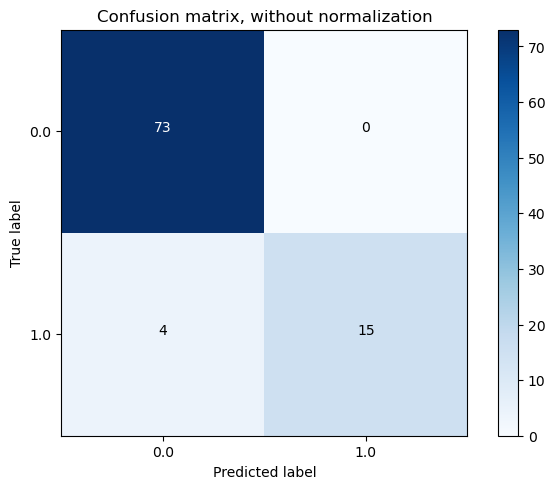

Normalized confusion matrix


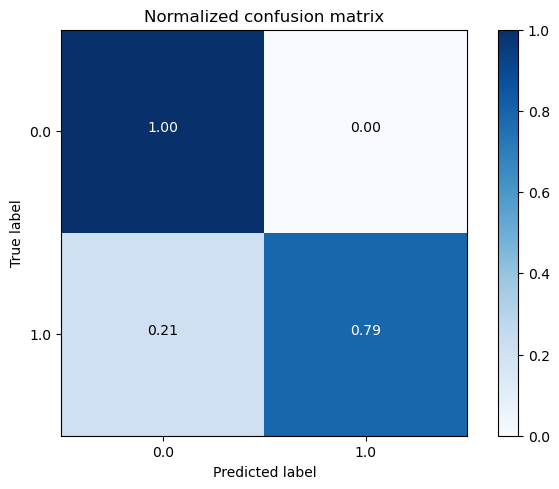

In [39]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### BL

In [47]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [48]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: BL


In [49]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [50]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [51]:
#Running randomized CV to narrow grid for GridSearch CV
#Modified from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

print(random_grid)

{'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'n_estimators': [50, 65, 80, 100, 115, 130, 150], 'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [52]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rnd = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rnd, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_1, target_1)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'reg_lambda': 12.8, 'reg_alpha': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.5, 'gamma': 0}


In [53]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0.1,0.5,25.6]
learning_rate = [0.1, 0.5, 0.8]
max_depth = [6, 8, 10]
n_estimators = [100, 115, 130]
reg_alpha = [0.1, 0.8, 1.2]
reg_lambda = [0.1, 0.2, 0.3]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.846667 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.3}
Best: 0.813413 using {'gamma': 0.1, 'learning_rate': 0.8, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.3}
Best: 0.750000 using {'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.3}
Best: 0.796825 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.3}
Best: 0.780000 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.2}
Best: 0.781667 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.3}
Best: 0.778492 using {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best: 0.826746 using {'gamma': 0.1, 'learning_rate': 0.8, 'max_depth': 6, 'n

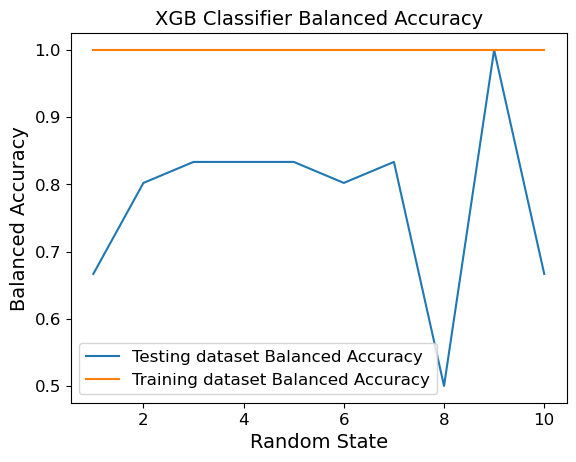

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 9


In [54]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-BL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [55]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.67 0.8  0.83 0.83 0.83 0.8  0.83 0.5  1.   0.67]


Feature: 0, Score: 0.04220
Feature: 1, Score: 0.02642
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01999
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00596
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.03894
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.06876
Feature: 19, Score: 0.00147
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00141
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.01484
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.01565
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

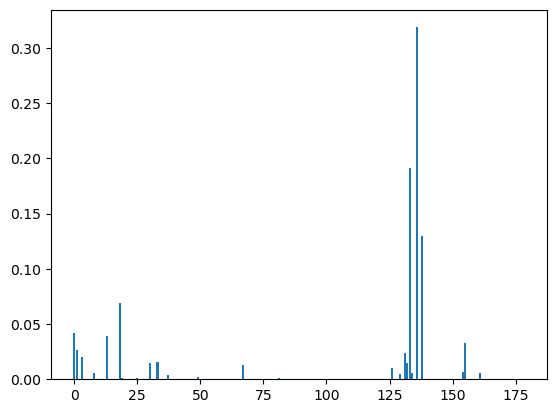

In [56]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 6, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 0.2)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.04220, Standard Deviation: 0.00000
Feature 1: Average Score: 0.02642, Standard Deviation: 0.00000
Feature 2: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 3: Average Score: 0.01999, Standard Deviation: 0.00000
Feature 4: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00596, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 11: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 12: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 13: Average Score: 0.03894, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

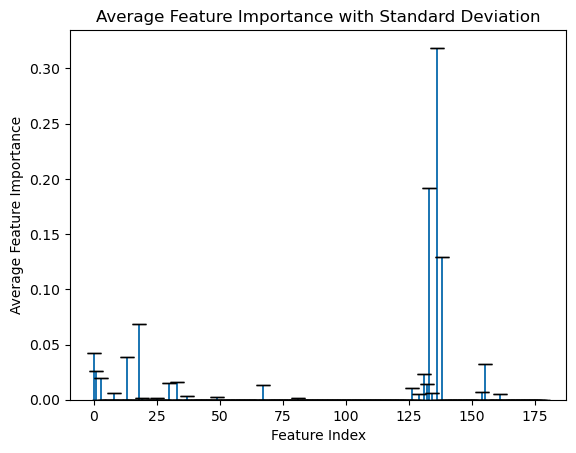

In [57]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 6, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 0.2)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [58]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 231.137876/11.76, Mean Score: 0.31875, Standard Deviation: 0.00000
Feature: 219.174255/14, Mean Score: 0.19172, Standard Deviation: 0.00000
Feature: 383.351339/20.58, Mean Score: 0.12951, Standard Deviation: 0.00000
Feature: 362.96926/9.15, Mean Score: 0.06876, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.04220, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.03894, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.03268, Standard Deviation: 0.00000
Feature: 426.966905/10.31, Mean Score: 0.02642, Standard Deviation: 0.00000
Feature: 367.212948/10.5, Mean Score: 0.02360, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.01999, Standard Deviation: 0.00000


In [59]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 231.137876/11.76, Mean Score: 0.31875, Standard Deviation: 0.00000
Feature: 219.174255/14, Mean Score: 0.19172, Standard Deviation: 0.00000
Feature: 383.351339/20.58, Mean Score: 0.12951, Standard Deviation: 0.00000
Feature: 362.96926/9.15, Mean Score: 0.06876, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.04220, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.03894, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.03268, Standard Deviation: 0.00000
Feature: 426.966905/10.31, Mean Score: 0.02642, Standard Deviation: 0.00000
Feature: 367.212948/10.5, Mean Score: 0.02360, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.01999, Standard Deviation: 0.00000


In [60]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_BL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_BL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 231.137876/11.76, Mean Score: 0.31875, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [61]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 6, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 0.2)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [62]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [63]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


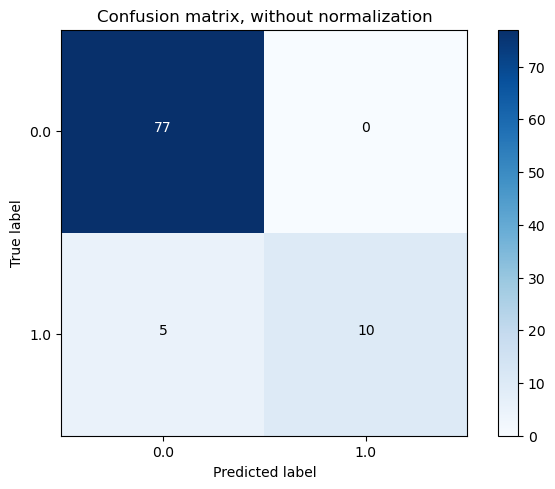

Normalized confusion matrix


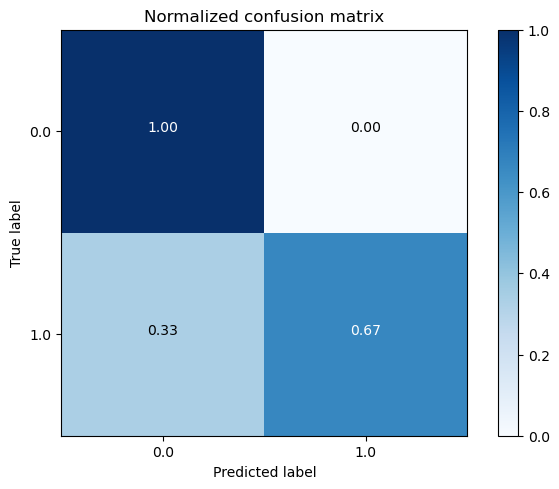

In [64]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### WWTP

In [65]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [66]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: WWTP


In [67]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [68]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [69]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [70]:
#Running randomized CV to narrow grid for GridSearch CV
#Modified from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

print(random_grid)

{'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'n_estimators': [50, 65, 80, 100, 115, 130, 150], 'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [71]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rnd = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rnd, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_1, target_1)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'reg_lambda': 0.8, 'reg_alpha': 0.8, 'n_estimators': 80, 'max_depth': 12, 'learning_rate': 0.4, 'gamma': 0.8}


In [72]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0.6,0.8,1]
learning_rate = [0.1, 0.4, 0.8]
max_depth = [10, 12, 20]
n_estimators = [70,80,90]
reg_alpha = [0.5, 0.8, 10]
reg_lambda = [0.5, 0.8, 10]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.913333 using {'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.917982 using {'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.5, 'reg_lambda': 10}
Best: 0.911404 using {'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.8, 'reg_lambda': 10}
Best: 0.917895 using {'gamma': 1, 'learning_rate': 0.8, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.8, 'reg_lambda': 0.5}
Best: 0.935877 using {'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.904649 using {'gamma': 0.8, 'learning_rate': 0.8, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.8, 'reg_lambda': 0.8}
Best: 0.904737 using {'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best: 0.917982 using {'gamma': 1, 'learning_rate': 0.8, 'max_depth': 10, 'n_esti

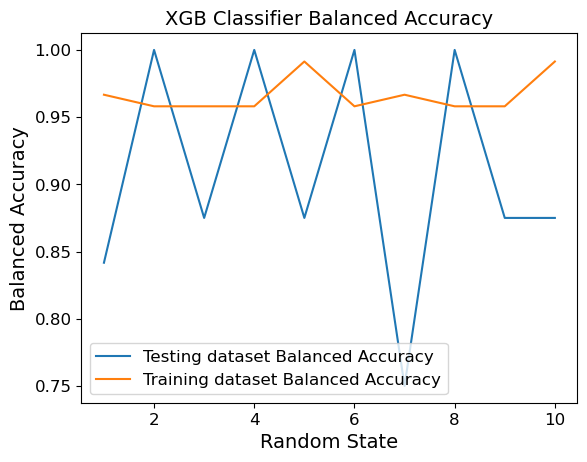

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 2


In [73]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-WWTP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [74]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[0.97 0.96 0.96 0.96 0.99 0.96 0.97 0.96 0.96 0.99]
[0.84 1.   0.88 1.   0.88 1.   0.75 1.   0.88 0.88]


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.06193
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

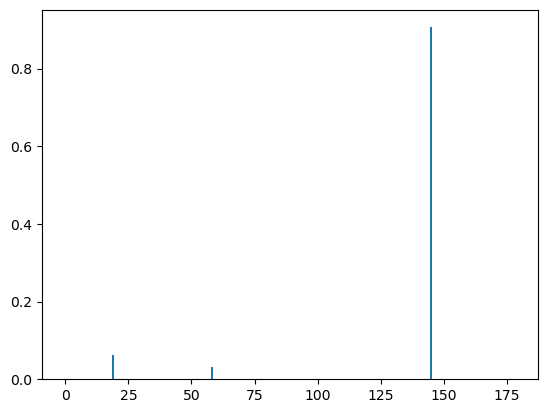

In [75]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 1, learning_rate = 0.8, max_depth = 10, n_estimators = 70, reg_alpha = 0.8, reg_lambda = 0.5)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 3: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 4: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 11: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 12: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 13: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

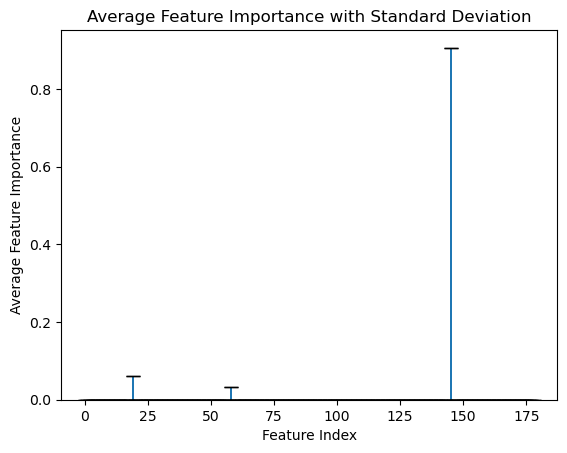

In [76]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 1, learning_rate = 0.8, max_depth = 10, n_estimators = 70, reg_alpha = 0.8, reg_lambda = 0.5)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [77]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 0.90620, Standard Deviation: 0.00000
Feature: 262.975752/7.22, Mean Score: 0.06193, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.03187, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 426.966905/10.31, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 348.939226/8.16, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 143.10736/7.81, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 498.929359/11.15, Mean Score: 0.00000, Standard Deviation: 0.00000


In [78]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 0.90620, Standard Deviation: 0.00000
Feature: 262.975752/7.22, Mean Score: 0.06193, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.03187, Standard Deviation: 0.00000
Feature: 353.30543/16.02, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 141.011121/7.52, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 237.164271/13.4, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 235.136869/10.02, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 198.059185/7.65, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 321.191381/6.65, Mean Score: 0.00000, Standard Deviation: 0.00000
Feature: 341.003615/9.37, Mean Score: 0.00000, Standard Deviation: 0.00000


In [79]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_WWTP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 285.079865/6.6, Mean Score: 0.90620, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [80]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 1, learning_rate = 0.8, max_depth = 10, n_estimators = 70, reg_alpha = 0.8, reg_lambda = 0.5)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [81]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [82]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


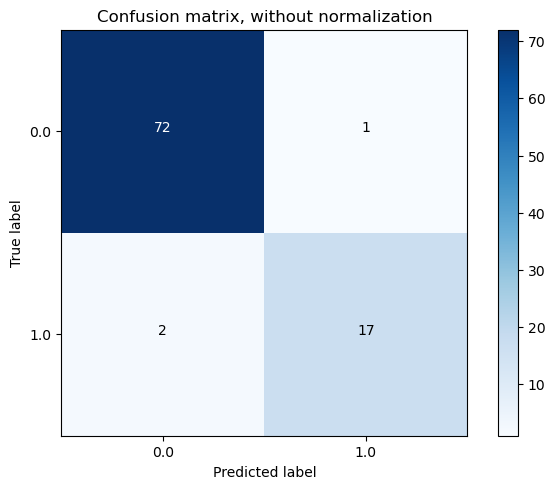

Normalized confusion matrix


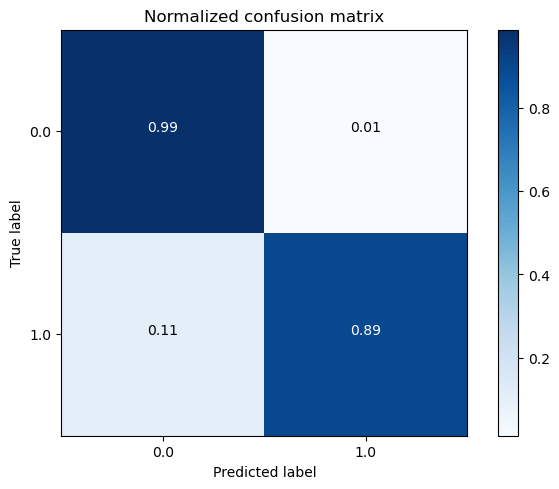

In [83]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### PP

In [84]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [85]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PP


In [86]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [87]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [88]:
#Running randomized CV to narrow grid for GridSearch CV
#Modified from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

print(random_grid)

{'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'n_estimators': [50, 65, 80, 100, 115, 130, 150], 'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [89]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rnd = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rnd, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_1, target_1)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'reg_lambda': 0.2, 'reg_alpha': 0.4, 'n_estimators': 115, 'max_depth': 12, 'learning_rate': 0.2, 'gamma': 0}


In [90]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0, 0.4, 0.6]
learning_rate = [0.2, 0.5, 0.15]
max_depth = [5,10, 12]
n_estimators = [40, 50, 115]
reg_alpha = [0.4, 0.8, 10]
reg_lambda = [0.2, 0.5, 0.8]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.835000 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 115, 'reg_alpha': 0.8, 'reg_lambda': 0.5}
Best: 0.771667 using {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.4, 'reg_lambda': 0.8}
Best: 0.821667 using {'gamma': 0.4, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.4, 'reg_lambda': 0.5}
Best: 0.805000 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.4, 'reg_lambda': 0.5}
Best: 0.828333 using {'gamma': 0.6, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.4, 'reg_lambda': 0.5}
Best: 0.831667 using {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.8, 'reg_lambda': 0.5}
Best: 0.790000 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 0.4, 'reg_lambda': 0.8}
Best: 0.816667 using {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 40

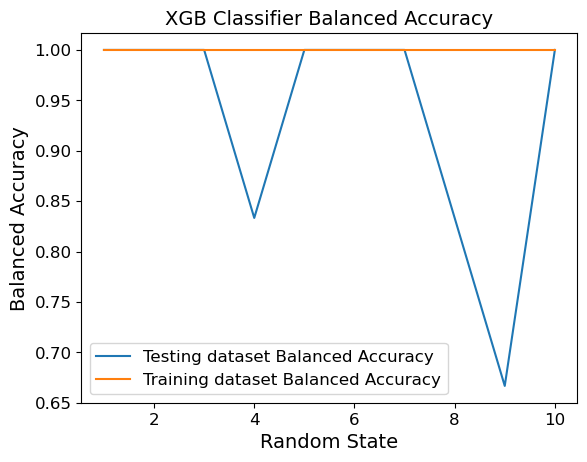

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [91]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-PP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [92]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   1.   0.83 1.   1.   1.   0.83 0.67 1.  ]


Feature: 0, Score: 0.07926
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.02040
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.22772
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00985
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.23955
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

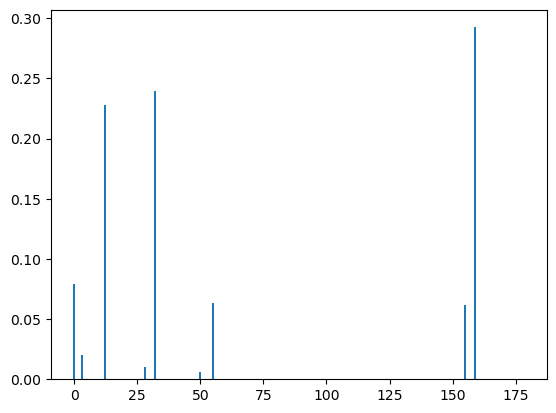

In [93]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 40, reg_alpha = 0.4, reg_lambda = 0.5)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.07926, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 3: Average Score: 0.02040, Standard Deviation: 0.00000
Feature 4: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 11: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 12: Average Score: 0.22772, Standard Deviation: 0.00000
Feature 13: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

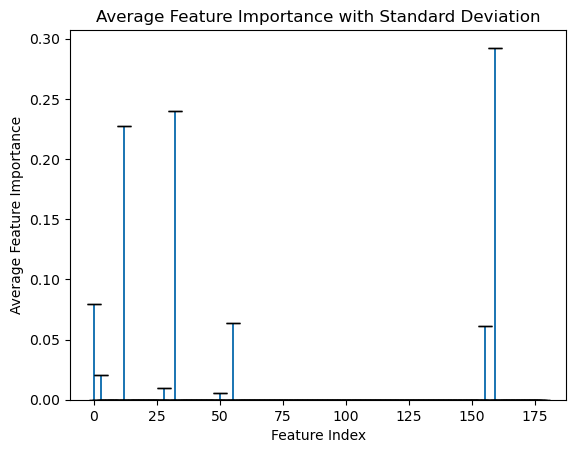

In [94]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 40, reg_alpha = 0.4, reg_lambda = 0.5)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [95]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 251.200899/15.84, Mean Score: 0.29253, Standard Deviation: 0.00000
Feature: 254.220132/16.9, Mean Score: 0.23955, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.22772, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.07926, Standard Deviation: 0.00000
Feature: 171.138736/11.07, Mean Score: 0.06335, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.06149, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.02040, Standard Deviation: 0.00000
Feature: 250.144232/14.25, Mean Score: 0.00985, Standard Deviation: 0.00000
Feature: 121.029456/6.51, Mean Score: 0.00583, Standard Deviation: 0.00000
Feature: 426.966905/10.31, Mean Score: 0.00000, Standard Deviation: 0.00000


In [96]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 251.200899/15.84, Mean Score: 0.29253, Standard Deviation: 0.00000
Feature: 254.220132/16.9, Mean Score: 0.23955, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.22772, Standard Deviation: 0.00000
Feature: 498.92902/11.61, Mean Score: 0.07926, Standard Deviation: 0.00000
Feature: 171.138736/11.07, Mean Score: 0.06335, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.06149, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.02040, Standard Deviation: 0.00000
Feature: 250.144232/14.25, Mean Score: 0.00985, Standard Deviation: 0.00000
Feature: 121.029456/6.51, Mean Score: 0.00583, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.00000, Standard Deviation: 0.00000


In [97]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_PP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 251.200899/15.84, Mean Score: 0.29253, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [98]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 0, learning_rate = 0.5, max_depth = 5, n_estimators = 40, reg_alpha = 0.4, reg_lambda = 0.5)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [99]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [100]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


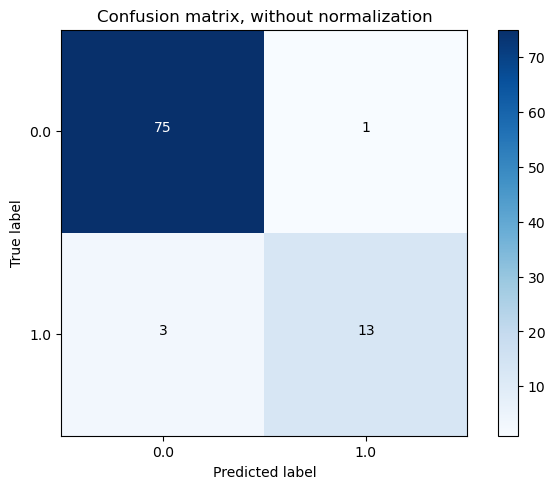

Normalized confusion matrix


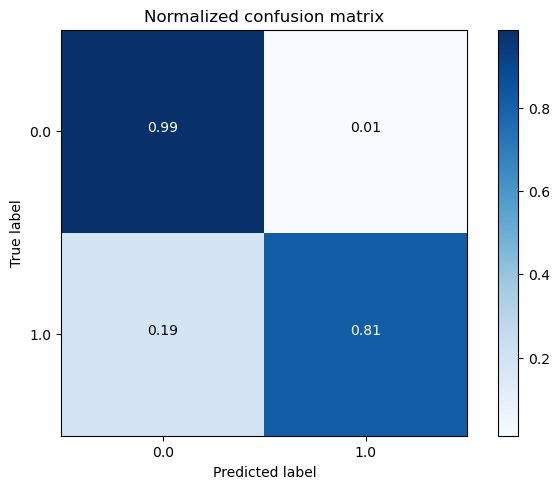

In [101]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### PG

In [102]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [103]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PG


In [104]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [105]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [106]:
#Running randomized CV to narrow grid for GridSearch CV
#Modified from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
random_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

print(random_grid)

{'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'n_estimators': [50, 65, 80, 100, 115, 130, 150], 'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200], 'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [107]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rnd = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rnd, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_1, target_1)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'reg_lambda': 0.1, 'reg_alpha': 0.8, 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.4, 'gamma': 0.4}


In [108]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

#Define hyperparameters
gamma = [0, 0.2, 0.4]
learning_rate = [0, 0.2, 0.4]
max_depth = [10, 11, 12]
n_estimators = [90, 100, 110]
reg_alpha = [0.2, 0.8, 1.0]
reg_lambda = [0.1, 0.2, 0.3]

grid = dict(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create xgboost
    xgbo = XGBClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=xgbo, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.598485 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.3}
Best: 0.616667 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.1}
Best: 0.550000 using {'gamma': 0.4, 'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.3}
Best: 0.600000 using {'gamma': 0, 'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.3}
Best: 0.616667 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.8, 'reg_lambda': 0.1}
Best: 0.581818 using {'gamma': 0, 'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
Best: 0.533333 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 0.1}
Best: 0.566667 using {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators':

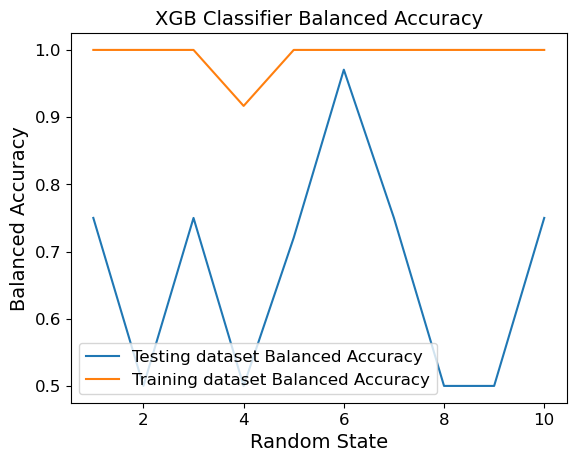

Best Testing Balanced Accuracy: 0.9705882352941176
Corresponding Random State: 6


In [109]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('XGB Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('XGB-Tuning-NORM-PG.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [110]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1.   1.   1.   0.92 1.   1.   1.   1.   1.   1.  ]
[0.75 0.5  0.75 0.5  0.72 0.97 0.75 0.5  0.5  0.75]


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.03930
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.03636
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00677
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.07997
Feature: 13, Score: 0.04423
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.02563
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.02734
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

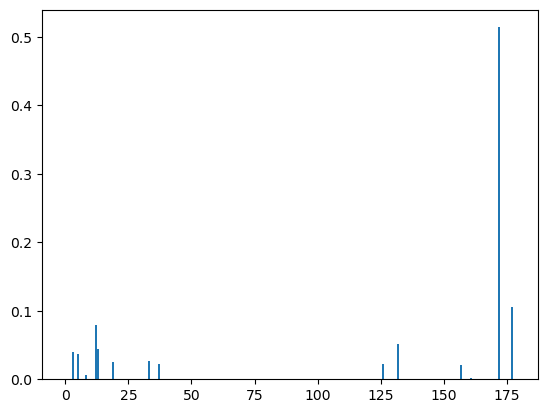

In [111]:
#Now running optimized model over the entire dataset
model = XGBClassifier(gamma = 0, learning_rate = 0.4, max_depth = 10, n_estimators = 90, reg_alpha = 0.2, reg_lambda = 0.2)
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 3: Average Score: 0.03930, Standard Deviation: 0.00000
Feature 4: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 5: Average Score: 0.03636, Standard Deviation: 0.00000
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00677, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 11: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 12: Average Score: 0.07997, Standard Deviation: 0.00000
Feature 13: Average Score: 0.04423, Standard Deviation: 0.00000
Feature 14: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 15: Average Score: 0.00000, Standard Devia

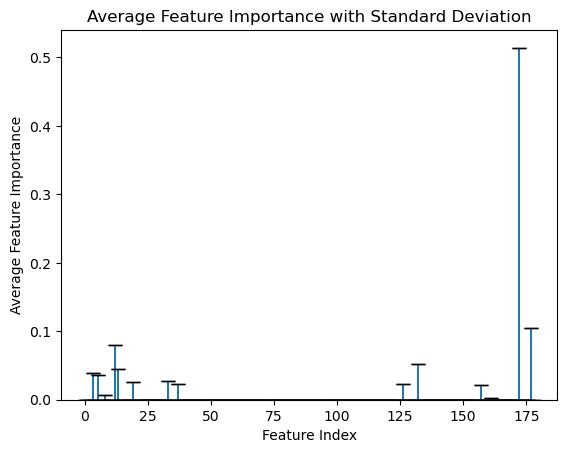

In [112]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = XGBClassifier(gamma = 0, learning_rate = 0.4, max_depth = 10, n_estimators = 90, reg_alpha = 0.2, reg_lambda = 0.2)
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [113]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.51419, Standard Deviation: 0.00000
Feature: 126.90497/17.2, Mean Score: 0.10496, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.07997, Standard Deviation: 0.00000
Feature: 295.263376/19.32, Mean Score: 0.05192, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.04423, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.03930, Standard Deviation: 0.00000
Feature: 143.10736/7.81, Mean Score: 0.03636, Standard Deviation: 0.00000
Feature: 254.219779/16.7, Mean Score: 0.02734, Standard Deviation: 0.00000
Feature: 262.975752/7.22, Mean Score: 0.02563, Standard Deviation: 0.00000
Feature: 277.216339/16.55, Mean Score: 0.02304, Standard Deviation: 0.00000


In [114]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.51419, Standard Deviation: 0.00000
Feature: 126.90497/17.2, Mean Score: 0.10496, Standard Deviation: 0.00000
Feature: 171.138549/9.93, Mean Score: 0.07997, Standard Deviation: 0.00000
Feature: 295.263376/19.32, Mean Score: 0.05192, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.04423, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.03930, Standard Deviation: 0.00000
Feature: 143.10736/7.81, Mean Score: 0.03636, Standard Deviation: 0.00000
Feature: 254.219779/16.7, Mean Score: 0.02734, Standard Deviation: 0.00000
Feature: 262.975752/7.22, Mean Score: 0.02563, Standard Deviation: 0.00000
Feature: 277.216339/16.55, Mean Score: 0.02304, Standard Deviation: 0.00000


In [115]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_PG.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PG.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Top Features with Significant Importance:
1. Feature: 126.90512/19.91, Mean Score: 0.51419, Standard Deviation: 0.00000


AttributeError: 'DataFrame' object has no attribute 'append'

In [116]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = XGBClassifier(gamma = 0.2, learning_rate = 0.4, max_depth = 10, n_estimators = 90, reg_alpha = 0.2, reg_lambda = 0.1)
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [117]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [118]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


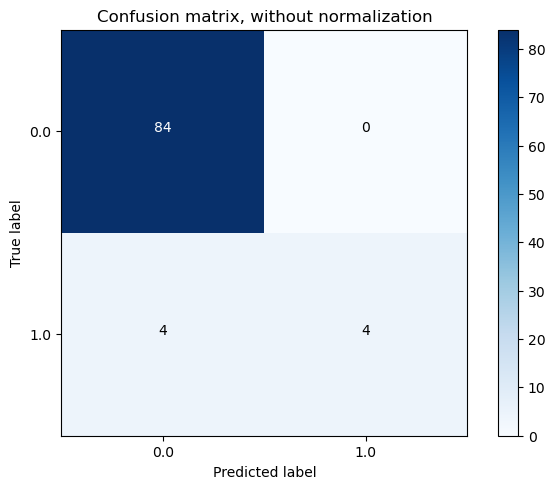

Normalized confusion matrix


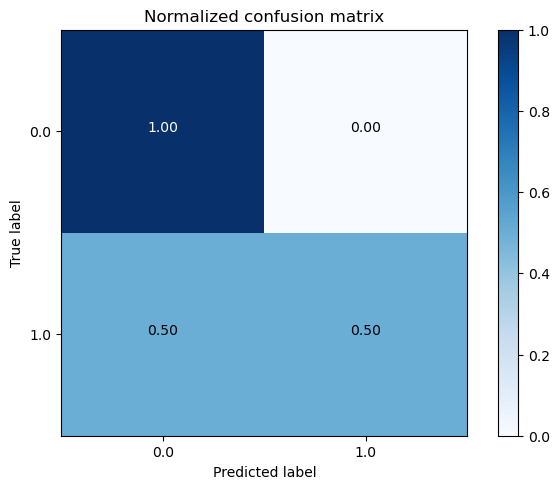

In [119]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)